In [23]:
from Acquisition_config import ACQUISITION_CONFIG
import sys
import time
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\Synth')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\Exceptions')
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\DAQ')
import Synthesizer
from logs.logging_config import LOGGING_CONFIG
from logging.config import dictConfig
import logging
import json
from Exceptions import replace_non_serializable
import DAQ
import niscope as ni
import numpy as np
import matplotlib.pyplot as plt

In [24]:
filepath = r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\API'

In [25]:
dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
logger.info('START EXECUTION')

14:47:30.034 - __main__ - <module> - INFO - START EXECUTION


In [26]:
try:
    cfg1 = json.dumps(replace_non_serializable(ACQUISITION_CONFIG))
    logger.info('Dumping acquisition configuration')
    with open(ACQUISITION_CONFIG['acq_conf']['path'] + 'config.json','w') as f:
        f.write(cfg1)
except Exception:
    logger.critical('Dumping acquisition configuration')
    raise SystemError("Could not dump acquisition configuration!")

14:47:30.507 - __main__ - <module> - INFO - Dumping acquisition configuration


In [27]:
try:
    daq = DAQ.DAQ()
    logger.info('DAQ class object correctly created')
except Exception:
    logger.critical('Could not crate DAQ class object')
    raise SyntaxError('Could not create DAQ class object')

14:47:31.065 - __main__ - <module> - INFO - DAQ class object correctly created


In [28]:
channels = {'I'			: 0, 
            'Q'			: 1,
            'trigger'	: 0}

In [29]:
devicename =  'PXI1Slot4'

In [30]:
try:
    daq.reset_with_def()
    daq.get_status
    logger.info('Resetting DAQ with defaults')
except Exception:
    logger.error('Could not reset DAQ with defaults')
    pass

14:47:32.020 - __main__ - <module> - ERROR - Could not reset DAQ with defaults


In [31]:
try:
    daq.acq_conf = ACQUISITION_CONFIG['acq_conf']
    logger.info('Inserting acquisition configuration from ACQUISITION_CONFIG dictionary')
except Exception:
    logger.warning('Coulkd not insert acquisition configuration')
    raise SystemError('Coulkd not insert acquisition configuration')

14:47:32.506 - __main__ - <module> - INFO - Inserting acquisition configuration from ACQUISITION_CONFIG dictionary


In [32]:
try:
    daq.horizontal_conf = ACQUISITION_CONFIG['horizontal']
    logger.info('Inserting hconf dic')
except Exception:
    logger.warning('Could not insert hconf dic')
    raise SystemError('Could not insert hconf dic')

14:47:32.925 - __main__ - <module> - INFO - Inserting hconf dic


In [33]:
try:
    daq.vertical_conf = ACQUISITION_CONFIG['vertical']
    logger.info('Inserting vconf dic')
except Exception:
    logger.warning('Could not insert vconf dic')
    raise SystemError('Could not insert vconf dic')

14:47:33.331 - __main__ - <module> - INFO - Inserting vconf dic


In [34]:
try:
    daq.chan_conf = ACQUISITION_CONFIG['chan_conf']
    logger.info('Inserting chan char dic')
except Exception:
    logger.warning('Could not insert chan char dic')
    raise SystemError('Could not insert chan char dic')

14:47:33.707 - __main__ - <module> - INFO - Inserting chan char dic


In [35]:
try:
    daq.trigger_dic = ACQUISITION_CONFIG['trigger']
    logger.info('Inserting trigger dic')
except Exception:
    logger.warning('Could not insert trigger dic')
    raise SystemError('Could not insert trigger dic')

14:47:34.238 - __main__ - <module> - INFO - Inserting trigger dic


In [36]:
import sys
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\diodo')
import diodo

In [37]:
pulser = diodo.AFG310()

In [38]:
amp = 1
pulser.reset()
pulser.set_offset(amp*0.5)
pulser.set_amplitude(amp)
pulser.set_func('SQU')
pulser.trigger_mode()
pulser.set_freq(1*1e6)
pulser.outp_on()

In [39]:
daq._session = ni.Session(devicename)
daq.config_trigger()
with daq._session as session:
        logger.info('Configuring channels')
        daq.configure_channels()
        data = {'CH0': [],
                'CH1': [],
                'CH2': [],
                'CH3': []   
                }

        daq._session.initiate()
        waveforms = []
        for _ in range(10):
                time.sleep(1)
                pulser.execute_trigger()
                waveforms.append(session.channels[0, 1].fetch())

14:47:37.693 - __main__ - <module> - INFO - Configuring channels


In [40]:
for i in range(len(waveforms)):
    data['CH0'].extend(np.array(waveforms[i][0].samples.tolist()))
    data['CH1'].extend(np.array(waveforms[i][1].samples.tolist()))  

In [41]:
T = np.arange(0,len(data['CH0']),1)

In [42]:
P = np.array(data['CH1'])
D = np.array(data['CH0'])

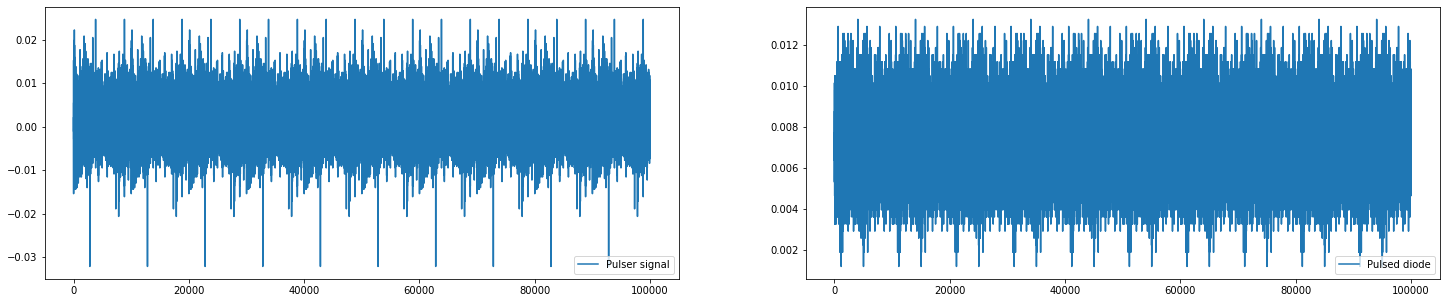

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(25,5))
axs[0].plot(T, P, label='Pulser signal')
axs[1].plot(T, D, label='Pulsed diode')
axs[0].legend()
#axs[0].set_xlim([0,10000])
axs[1].legend()